In [1]:
import logging
logging.basicConfig()
logger = logging.getLogger()

In [21]:
from __future__ import annotations

import numpy as np  # type: ignore
from uuid import uuid4

from pathlib import Path
import math
import operator
from functools import partial
from dataclasses import dataclass, field
from typing import (Union, Callable)

import h5py as h5
import pandas as pd  # type: ignore
from plotnine import ggplot, geom_line, aes  # type: ignore

from pintFoam.parareal.forward_euler import forward_euler
from pintFoam.parareal.iterate_solution import iterate_solution
from pintFoam.parareal.tabulate_solution import tabulate
from pintFoam.parareal.harmonic_oscillator import (underdamped_solution, harmonic_oscillator)

OMEGA0 = 1.0
ZETA = 0.5
H = 0.001
ARCHIVE = Path("harmonic_oscillator.h5")
system = harmonic_oscillator(OMEGA0, ZETA)

class Vector:
    def __add__(self, other):
        return BinaryExpr(operator.add, self, other)

    def __sub__(self, other):
        return BinaryExpr(operator.sub, self, other)

    def __mul__(self, scale):
        return UnaryExpr(partial(operator.mul, scale), self)

    def __rmul__(self, scale):
        return UnaryExpr(partial(operator.mul, scale), self)


@dataclass
class H5Snap(Vector):
    loc: str
    slice: list[Union[None, int, slice]]

    def data(self, f):
        return f[self.loc].__getitem__(tuple(self.slice))

    def reduce(self, f):
        return self.data(f)


@dataclass
class UnaryExpr(Vector):
    func: Callable[[np.NDArray], np.NDArray]
    inp: Vector

    def reduce(self, f):
        a = reduce_expr(self.inp, f)
        return self.func(a)


@dataclass
class BinaryExpr(Vector):
    func: Callable[[np.NDArray, np.NDArray], np.NDArray]
    inp1: Vector
    inp2: Vector

    def reduce(self, f):
        a = reduce_expr(self.inp2, f)
        b = reduce_expr(self.inp2, f)
        return self.func(a, b)


@dataclass
class LiteralExpr(Vector):
    value: np.NDArray

    def reduce(self, f):
        return self.value
        

def reduce_expr(expr, f):
    try:
        return expr.reduce(f)
    except AttributeError:
        return expr
    

def coarse(n, y, t0, t1):
    with h5.File(ARCHIVE, "a") as f:
        return LiteralExpr(forward_euler(system)(reduce_expr(y, f), t0, t1))


class Index:
    def __getitem__(self, idx):
        if isinstance(idx, tuple):
            return list(idx)
        else:
            return [idx]

index = Index()

# fine :: Solution[NDArray]
def fine(n_iter, y, t0, t1):
    n = math.ceil((t1 - t0) / H)
    t = np.linspace(t0, t1, n + 1)
    with h5.File(ARCHIVE, "a") as f:
        logger.debug("fine %f - %f", t0, t1)
        y0 = reduce_expr(y, f)
        logger.debug("    %s", y0)
        x = tabulate(forward_euler(system), reduce_expr(y, f), t)
        
        loc = f"{n_iter:04}/fine-{int(t0*1000):06}-{int(t1*1000):06}-{uuid4().hex}"
        ds = f.create_dataset(loc, data=x)
        ds.attrs["t0"] = t0
        ds.attrs["t1"] = t1
        ds.attrs["n"] = n
    return H5Snap(loc, index[-1])


y0 = np.array([1.0, 0.0])
t = np.linspace(0.0, 15.0, 10)
exact_result = underdamped_solution(OMEGA0, ZETA)(t)
euler_result = tabulate(partial(fine, 0), LiteralExpr(y0), t)
with h5.File(ARCHIVE, "r") as f:
    euler_result_np = np.array([reduce_expr(y, f) for y in euler_result])

data = pd.DataFrame({
    "time": t,
    "exact_q": exact_result[:,0],
    "exact_p": exact_result[:,1],
    "euler_q": euler_result_np[:,0],
    "euler_p": euler_result_np[:,1]})

plot = ggplot(data) \
    + geom_line(aes("time", "exact_q")) \
    + geom_line(aes("time", "euler_q"), color="#000088")

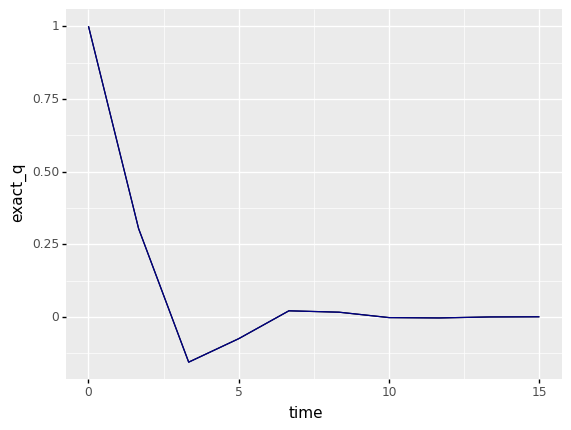

<ggplot: (8768037192245)>

In [16]:
plot

In [18]:
euler_result_np

array([[ 1.00000000e+00,  0.00000000e+00],
       [ 3.03946923e-01, -4.98016008e-01],
       [-1.55636213e-01, -5.47209219e-02],
       [-7.45570431e-02,  8.81289648e-02],
       [ 2.12282515e-02,  2.00274934e-02],
       [ 1.64262740e-02, -1.44587264e-02],
       [-2.20796176e-03, -5.37455561e-03],
       [-3.34771792e-03,  2.14263540e-03],
       [ 4.95381691e-05,  1.25139782e-03],
       [ 6.38273122e-04, -2.67528432e-04]])

In [22]:
from pintFoam.parareal.futures import (Parareal)
from dask.distributed import Client


@dataclass
class History:
    history: list[Vector] = field(default_factory=list)
    
    def convergence_test(self, y) -> bool:
        self.history.append(y)
        if len(self.history) < 2:
            return False
        with h5.File(ARCHIVE, "r") as f:
            a = reduce_expr(self.history[-2], f)
            b = reduce_expr(self.history[-1], f)
            return np.allclose(a, b, atol=1e-4)


client = Client()
p = Parareal(client, lambda n: partial(coarse, n), lambda n: partial(fine, n))
p.schedule(LiteralExpr(y0), t)
history = History()
p.wait(jobs, history.convergence_test)

distributed.worker - WARNING - Compute Failed
Function:  fine
args:      (LiteralExpr(value=array([ 1.        , -1.66666667])), 1.6666666666666667, 3.3333333333333335)
kwargs:    {}
Exception: 'BlockingIOError(11, "Unable to open file (unable to lock file, errno = 11, error message = \'Resource temporarily unavailable\')")'

distributed.worker - WARNING - Compute Failed
Function:  fine
args:      (LiteralExpr(value=array([1., 0.])), 0.0, 1.6666666666666667)
kwargs:    {}
Exception: 'BlockingIOError(11, "Unable to open file (unable to lock file, errno = 11, error message = \'Resource temporarily unavailable\')")'

distributed.worker - WARNING - Compute Failed
Function:  fine
args:      (LiteralExpr(value=array([1., 0.])), 0.0, 1.6666666666666667)
kwargs:    {}
Exception: 'BlockingIOError(11, "Unable to open file (unable to lock file, errno = 11, error message = \'Resource temporarily unavailable\')")'

distributed.worker - WARNING - Compute Failed
Function:  coarse
args:      (LiteralEx

NameError: name 'jobs' is not defined

distributed.worker - WARNING - Compute Failed
Function:  coarse
args:      (LiteralExpr(value=array([2.85185185, 2.28395062])), 6.666666666666667, 8.333333333333334)
kwargs:    {}
Exception: 'BlockingIOError(11, "Unable to open file (unable to lock file, errno = 11, error message = \'Resource temporarily unavailable\')")'

distributed.worker - WARNING - Compute Failed
Function:  fine
args:      (LiteralExpr(value=array([1., 0.])), 0.0, 1.6666666666666667)
kwargs:    {}
Exception: 'BlockingIOError(11, "Unable to open file (unable to lock file, errno = 11, error message = \'Resource temporarily unavailable\')")'

distributed.worker - WARNING - Compute Failed
Function:  coarse
args:      (LiteralExpr(value=array([1., 0.])), 0.0, 1.6666666666666667)
kwargs:    {}
Exception: 'BlockingIOError(11, "Unable to open file (unable to lock file, errno = 11, error message = \'Resource temporarily unavailable\')")'

distributed.worker - WARNING - Compute Failed
Function:  fine
args:      (LiteralExpr

In [4]:
data = pd.DataFrame({
    "time": t,
    "exact_q": exact_result[:,0],
    "exact_p": exact_result[:,1],
    "euler_q": euler_result[:,0],
    "euler_p": euler_result[:,1]})

for i,k in enumerate(y):
    data.insert(5+(i*2), f"parareal_{i:02}_q", k[:,0])
    data.insert(6+(i*2), f"parareal_{i:02}_p", k[:,1])

data

,time,exact_q,exact_p,euler_q,euler_p,parareal_00_q,parareal_00_p,parareal_01_q,parareal_01_p,parareal_02_q,...,parareal_06_q,parareal_06_p,parareal_07_q,parareal_07_p,parareal_08_q,parareal_08_p,parareal_09_q,parareal_09_p,parareal_10_q,parareal_10_p
0,0.000000,1.000000,-0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,1.666667,0.304108,-0.497762,0.303947,-0.498016,1.000000,-1.666667,0.303947,-0.498016,0.303947,...,0.303947,-0.498016,0.303947,-0.498016,0.303947,-0.498016,0.303947,-0.498016,0.303947,-0.498016
2,3.333333,-0.155286,-0.054980,-0.155636,-0.054721,-1.777778,-0.555556,0.725618,0.206420,-0.155636,...,-0.155636,-0.054721,-0.155636,-0.054721,-0.155636,-0.054721,-0.155636,-0.054721,-0.155636,-0.054721
3,5.000000,-0.074591,0.087942,-0.074557,0.088129,-2.703704,3.333333,2.956330,-3.687133,-0.993140,...,-0.074557,0.088129,-0.074557,0.088129,-0.074557,0.088129,-0.074557,0.088129,-0.074557,0.088129
4,6.666667,0.021091,0.020098,0.021228,0.020027,2.851852,2.283951,-5.202472,-4.053489,3.327105,...,0.021228,0.020027,0.021228,0.020027,0.021228,0.020027,0.021228,0.020027,0.021228,0.020027
5,8.333333,0.016418,-0.014390,0.016426,-0.014459,6.658436,-6.275720,-16.612467,15.785320,15.918757,...,0.016426,-0.014459,0.016426,-0.014459,0.016426,-0.014459,0.016426,-0.014459,0.016426,-0.014459
6,10.000000,-0.002170,-0.005385,-0.002208,-0.005375,-3.801097,-6.913580,12.395900,21.979394,-16.355697,...,-0.002208,-0.005375,-0.002208,-0.005375,-0.002208,-0.005375,-0.002208,-0.005375,-0.002208,-0.005375
7,11.666667,-0.003341,0.002123,-0.003348,0.002143,-15.323731,10.944216,59.753548,-43.022258,-97.885622,...,-1.263554,0.943187,-0.003348,0.002143,-0.003348,0.002143,-0.003348,0.002143,-0.003348,0.002143
8,13.333333,0.000041,0.001252,0.000050,0.001251,2.916629,18.243408,-14.074050,-83.643620,29.166685,...,2.243084,10.757085,-0.222533,-1.026753,0.000050,0.001251,0.000050,0.001251,0.000050,0.001251
9,15.000000,0.000635,-0.000263,0.000638,-0.000268,33.322309,-17.023320,-176.830383,91.249474,412.205023,...,83.407697,-45.083098,-16.066369,8.760544,1.356946,-0.746221,0.000638,-0.000268,0.000638,-0.000268
